In [6]:
import cv2
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import itertools

In [7]:
img = cv2.imread('./source/100-1.jpg')
template = cv2.imread('./template/100-Template.jpg')

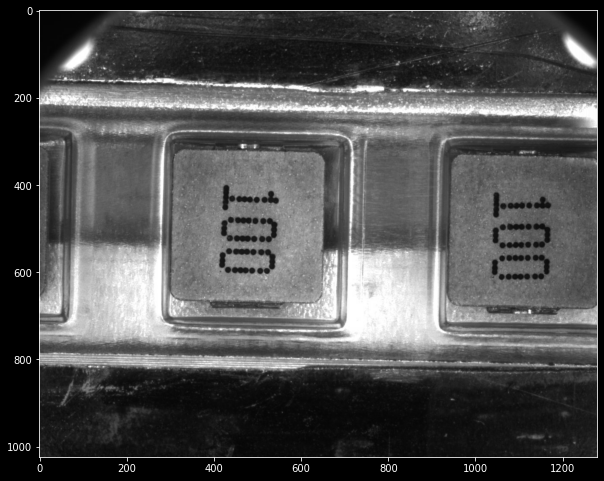

In [8]:
plt.figure(figsize=(10, 10))
plt.imshow(img)

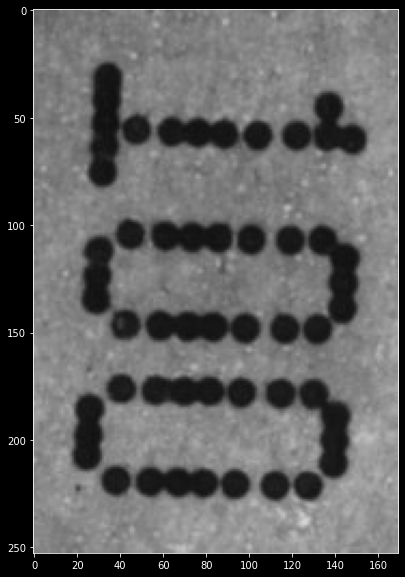

In [9]:
plt.figure(figsize=(10, 10))
plt.imshow(template)

In [10]:
def conv(x, y):
    # pad
    pad = np.array(y.shape) // 2
    padded_x = np.ones([x.shape[0] + pad[0]*2, x.shape[1] + pad[1]*2]) * 0
    padded_x[pad[0]:-pad[0], pad[1]:-pad[1]] = x
    
    # conv windows
    view_shape = tuple(np.subtract(padded_x.shape, y.shape) + 1) + y.shape
    strides = padded_x.strides + padded_x.strides
    sub_matrices = np.lib.stride_tricks.as_strided(padded_x, view_shape, strides)

    # einsum method
    y = np.flipud(np.fliplr(y))

    m = np.einsum('ij,klij->kl', y, sub_matrices)

    return m

def CrossCorrelation(x, y):
    # pad
    pad = np.array(y.shape) // 2
    padded_x = np.ones([x.shape[0] + pad[0]*2, x.shape[1] + pad[1]*2]) * 0
    padded_x[pad[0]:-pad[0], pad[1]:-pad[1]] = x
    
    # conv windows
    view_shape = tuple(np.subtract(padded_x.shape, y.shape) + 1) + y.shape
    strides = padded_x.strides + padded_x.strides
    sub_matrices = np.lib.stride_tricks.as_strided(padded_x, view_shape, strides)

    # einsum method
    m = np.einsum('ij,klij->kl', y, sub_matrices)

    return m

In [11]:
img = img[:, :, 2]*0.299 + img[:, :, 1]*0.587 + img[:, :, 0]*0.114
img = img.astype(np.uint8)

template = template[:, :, 2]*0.299 + template[:, :, 1]*0.587 + template[:, :, 0]*0.114
template = template.astype(np.uint8)

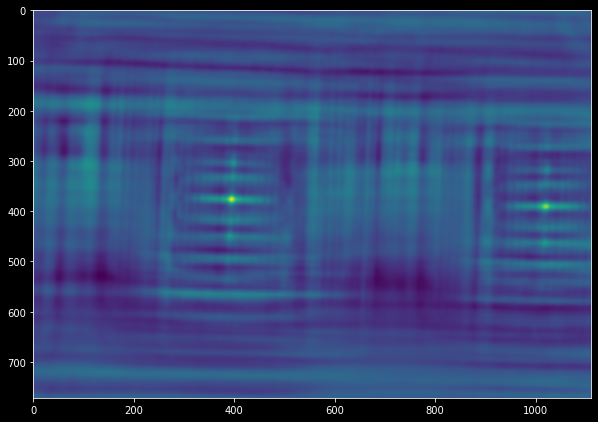

In [12]:
# openCV
res = cv2.matchTemplate(img, template, cv2.TM_CCOEFF_NORMED)

plt.figure(figsize=(10, 10))
plt.imshow(res)

In [13]:
res = cv2.matchShapes(img, template, cv2.CONTOURS_MATCH_I1, 0.0)

print(res)

0.005957295660729001


In [14]:
sobel_x = [[1, 0, -1],
           [2, 0, -2],
           [1, 0, -1]]

sobel_y = [[1, 2, 1],
           [0, 0, 0],
           [-1, -2, -1]]

sobel_x = np.array(sobel_x)
sobel_y = np.array(sobel_y)

In [15]:
Ix = conv(img, sobel_x)
Iy = conv(img, sobel_y)

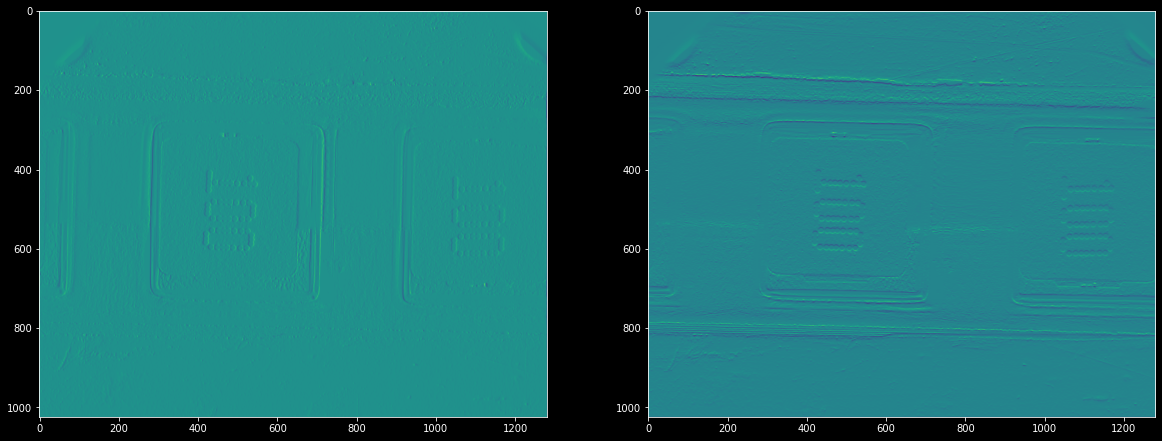

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(Ix)
ax[1].imshow(Iy)

In [17]:
window_size = 15

window = np.ones([window_size, window_size])

In [18]:
pad = np.array(window.shape) // 2
padded_x = np.ones([Ix.shape[0] + pad[0]*2, Ix.shape[1] + pad[1]*2]) * 0
padded_x[pad[0]:-pad[0], pad[1]:-pad[1]] = Ix

view_shape = tuple(np.subtract(padded_x.shape, window.shape) + 1) + window.shape
strides = padded_x.strides + padded_x.strides
sub_matrices_Ix = np.lib.stride_tricks.as_strided(padded_x, view_shape, strides)

In [19]:
# padad = np.array(window.shape) // 2
padded_x = np.ones([Iy.shape[0] + pad[0]*2, Iy.shape[1] + pad[1]*2]) * 0
padded_x[pad[0]:-pad[0], pad[1]:-pad[1]] = Iy

view_shape = tuple(np.subtract(padded_x.shape, window.shape) + 1) + window.shape
strides = padded_x.strides + padded_x.strides
sub_matrices_Iy = np.lib.stride_tricks.as_strided(padded_x, view_shape, strides)

In [20]:
def get_guassKernal(l=5, sig=1.) -> np.ndarray:
    """\
    creates gaussian kernel with side length `l` and a sigma of `sig`
    """
    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sig))
    kernel = np.outer(gauss, gauss)
    return kernel / np.sum(kernel)

In [21]:
sigma = 0.3 * ((window_size - 1) * 0.5 - 1) + 0.8
guass_kernal = get_guassKernal(l=window_size, sig=sigma)

In [22]:
M = np.zeros([*img.shape, 2, 2])

M[:, :, 0, 0] = np.einsum('klij,klij,ij->kl', sub_matrices_Ix, sub_matrices_Ix, guass_kernal)
M[:, :, 0, 1] = np.einsum('klij,klij,ij->kl', sub_matrices_Ix, sub_matrices_Iy, guass_kernal)
M[:, :, 1, 0] = np.einsum('klij,klij,ij->kl', sub_matrices_Ix, sub_matrices_Iy, guass_kernal)
M[:, :, 1, 1] = np.einsum('klij,klij,ij->kl', sub_matrices_Iy, sub_matrices_Iy, guass_kernal)

In [23]:
E = np.zeros([*img.shape, 2])
E[:, :], _ = np.linalg.eig(M)

In [24]:
traceM = E[:, :, 0] + E[:, :, 1]
detM = E[:, :, 0] * E[:, :, 1]
k = 0.04
R = detM - k * traceM ** 2

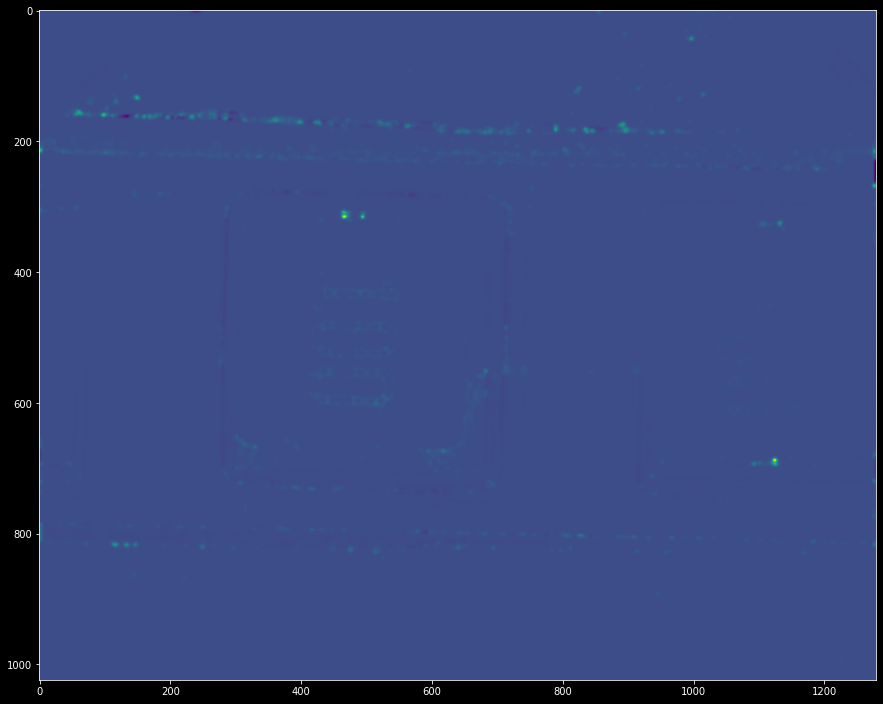

In [25]:
plt.figure(figsize=(15, 15))
plt.imshow(R)